In [7]:
import pandas as pd
import sys 
import os
import pickle
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import time  # 引入time模块
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.metrics import mean_squared_error
from itertools import chain
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.layers import combined_dnn_input, concat_func, add_func, FM, DNN_UDG, rig, rmse, CustomCallback,focal_loss,get_input
from deepctr.models import DeepFM, DeepFM_UDG, PNN, PNN_UDG, WDL, WDL_UDG, DIEN, DIEN_UDG, DIN, DIN_UDG
from deepctr.inputs import create_embedding_dict, embedding_lookup
from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names, build_input_features, get_linear_logit,input_from_feature_columns

In [8]:
train = pd.read_csv('../dataset/alimama/a.csv')
test = pd.read_csv('../dataset/alimama/b.csv')

In [283]:
test = test.drop(['timestamp', 'Unnamed: 0', 'hist_item_list', 'hist_cate_list', 'neg_hist_item_list', 'neg_hist_cate_list'], axis=1)

In [26]:
max_num = 0
item = 0
for x in test['itemId']:
    num = len(test[test['itemId']==x])
    if num > max_num:
        item = x
        max_num = num
print(max_num, item)

515 143566


In [41]:
test[test['itemId']==143566]

,Unnamed: 0,userId,timestamp,itemId,rating,category,final_gender_code,age_level,hist_item_list,hist_cate_list,neg_hist_item_list,neg_hist_cate_list
958,958,479,1494605572,143566,1,1731,1,2,"['94975', '127266', '127266']","['1731', '1731', '1731']","['130999', '26152', '41910']","['1495', '1837', '1731']"
1156,1156,578,1494657298,143566,1,1731,1,4,"['53203', '126374', '53842', '75173', '118465']","['312', '819', '819', '1842', '1731']","['94836', '41336', '32948', '100249', '128197']","['949', '3767', '3982', '1912', '2080']"
1302,1302,651,1494665227,143566,1,1731,1,2,"['114520', '126013']","['820', '1731']","['9687', '128870']","['1658', '938']"
2094,2094,1047,1494414101,143566,1,1731,1,2,"['85888', '107667']","['206', '816']","['67434', '19081']","['1847', '532']"
2208,2208,1104,1494546589,143566,1,1731,1,2,"['97660', '97660']","['828', '828']","['105230', '49983']","['1843', '820']"
...,...,...,...,...,...,...,...,...,...,...,...,...
225686,225686,112843,1494680460,143566,1,1731,1,2,['104434'],['1731'],['134641'],['1842']
226020,226020,113010,1494587974,143566,1,1731,1,2,"['52545', '24394', '99491', '105513', '100411'...","['826', '826', '826', '817', '826', '1731', '2...","['134613', '92204', '23216', '115737', '111439...","['816', '3373', '3850', '2614', '631', '818', ..."
227024,227024,113512,1494645941,143566,1,1731,1,2,"['116775', '108225', '67659', '86084', '92658'...","['1731', '1731', '1731', '1731', '1731', '1731...","['50006', '64546', '81547', '130916', '9989', ...","['3547', '1848', '1842', '824', '3376', '3244'..."
227112,227112,113556,1494463222,143566,1,1731,1,3,"['102690', '103546', '45706', '112504', '47679...","['1731', '1731', '2044', '1731', '2044', '1731...","['61537', '67223', '5068', '20014', '37195', '...","['758', '1760', '3577', '816', '1429', '3121',..."


In [157]:
pd.value_counts(train['userId'])

111221    120
46388     120
8681      117
86834     115
84209     113
         ... 
45097       1
47144       1
51238       1
55332       1
34671       1
Name: userId, Length: 114465, dtype: int64

In [48]:
np.array(test[test['itemId']==143566]['age_level'].tolist()).reshape(1,515)

array([[2, 4, 2, 2, 2, 1, 1, 2, 4, 2, 5, 3, 2, 3, 2, 4, 3, 4, 3, 1, 3, 5,
        6, 2, 2, 2, 3, 3, 2, 4, 2, 4, 3, 3, 2, 2, 5, 3, 1, 3, 2, 2, 2, 2,
        2, 1, 3, 4, 5, 5, 1, 2, 5, 3, 5, 2, 3, 4, 3, 2, 1, 2, 3, 2, 2, 2,
        1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 3, 2, 2, 3, 4, 4, 3, 2, 3, 3, 3, 2,
        3, 1, 2, 1, 5, 4, 6, 2, 2, 2, 4, 2, 1, 1, 3, 1, 2, 4, 3, 1, 1, 1,
        4, 3, 4, 2, 3, 1, 2, 1, 2, 2, 3, 2, 2, 3, 3, 1, 2, 2, 2, 1, 1, 2,
        3, 1, 2, 2, 3, 2, 5, 3, 3, 1, 6, 2, 2, 3, 3, 5, 5, 3, 4, 1, 1, 2,
        2, 2, 2, 4, 5, 1, 2, 3, 2, 2, 1, 2, 5, 3, 5, 2, 4, 4, 2, 2, 2, 1,
        3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 3, 3, 5,
        2, 1, 1, 6, 3, 4, 2, 2, 3, 5, 2, 4, 2, 3, 5, 2, 3, 3, 3, 2, 3, 3,
        3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 4, 2, 3, 3, 2, 2, 3, 1, 2, 2, 2, 3,
        3, 1, 5, 3, 2, 2, 3, 2, 2, 3, 3, 5, 3, 4, 3, 1, 2, 2, 2, 3, 3, 2,
        5, 3, 4, 5, 3, 1, 2, 2, 3, 3, 4, 2, 3, 2, 5, 3, 3, 2, 4, 4, 3, 3,
        3, 3, 2, 3, 2, 1, 3, 3, 2, 2, 

In [83]:
data

[[array([25507]), array([111221]), array([2044]), array([0]), array([3])],
 [array([116049]), array([111221]), array([1837]), array([0]), array([3])],
 [array([39391]), array([111221]), array([2043]), array([0]), array([3])],
 [array([103733]), array([111221]), array([2080]), array([0]), array([3])],
 [array([67825]), array([111221]), array([2044]), array([0]), array([3])],
 [array([115266]), array([111221]), array([819]), array([0]), array([3])],
 [array([89672]), array([111221]), array([2044]), array([0]), array([3])],
 [array([79967]), array([111221]), array([1837]), array([0]), array([3])],
 [array([84825]), array([111221]), array([2044]), array([0]), array([3])],
 [array([32431]), array([111221]), array([1737]), array([0]), array([3])],
 [array([114206]), array([111221]), array([2044]), array([0]), array([3])],
 [array([40386]), array([111221]), array([1674]), array([0]), array([3])],
 [array([135544]), array([111221]), array([2044]), array([0]), array([3])],
 [array([98584]), arr

# Alimama

In [9]:
sparse_features = ["itemId", "userId", "category", 'final_gender_code', 'age_level']
#dense_features = ['price']
dense_features = []
#untrainable_features = ['category', 'final_gender_code', 'age_level']
#untrainable_features_columns = [SparseFeat(feat, train[feat].nunique(), embedding_dim=int(sys.argv[5]), 
                                           #trainable=False) for feat in untrainable_features]
untrainable_features = ["category", 'final_gender_code', 'age_level']
untrainable_features_columns = [SparseFeat(feat, train[feat].nunique(), embedding_dim=128, 
                                           trainable=False) for feat in untrainable_features]

udg_features = 'userId'
target = ['rating']
behavior_feature_list = ['itemId', 'category']

W1019 11:54:01.983285 140469963540288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
fixlen_feature_columns = [SparseFeat(feat, train[feat].nunique(), embedding_dim=128) for feat in sparse_features] + [DenseFeat(feat, 1,) for feat in dense_features]
linear_feature_columns = fixlen_feature_columns 
dnn_feature_columns = fixlen_feature_columns
fixlen_feature_names = get_feature_names(fixlen_feature_columns)

In [11]:
model_pnn = PNN(dnn_feature_columns, untrainable_features_columns, (200, 80))
model_pnn_udg = PNN_UDG(dnn_feature_columns, untrainable_features_columns, (200, 80), uid_feature_name=udg_features, 
                    udg_embedding_size=128)

W1019 11:54:03.833853 140469963540288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:253: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1019 11:54:03.851892 140469963540288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Tensor("flatten_1/Reshape:0", shape=(?, 650), dtype=float32)
Tensor("flatten_3/Reshape:0", shape=(?, 650), dtype=float32) Tensor("flatten_4/Reshape:0", shape=(?, 512), dtype=float32)
Tensor("concatenate_5/concat:0", shape=(?, 1162), dtype=float32)
1162 512
[[512, 650, 650], [512, 200, 200], [512, 80, 80]]


In [12]:
model_pnn.load_weights('./trained_data/model/PNN/alimama/0_0.8814_0.4368_0.3752_0.3699_2020-10-18 21:46:01.h5')
model_pnn_udg.load_weights('./trained_data/model/PNN_UDG/alimama/2_0.9514_0.318_0.3037_0.5412_2020-10-18 22:33:28.h5')

In [13]:
from tensorflow.keras.models import Model, load_model

pnn_uid_out = Model(inputs=model_pnn.input, outputs=model_pnn.layers[6].output)
pnn_dnn_out = Model(inputs=model_pnn.input, outputs=model_pnn.layers[18].output)

pnn_udg_uid_out = Model(inputs=model_pnn_udg.input, outputs=model_pnn_udg.layers[6].output)
pnn_udg_uid2_out = Model(inputs=model_pnn_udg.input, outputs=model_pnn_udg.layers[16].output)
pnn_udg_dnn_out = Model(inputs=model_pnn_udg.input, outputs=model_pnn_udg.layers[-3].output)

In [393]:
pd.value_counts(train1['userId']).keys()

Int64Index([111221,  46388,   8681,  86834,  84209, 110438,  90641,  17896,
             71601,  78202,
            ...
             18054,  26338,  56981,  38956,  63120,  45097,  47144,  51238,
             55332,  34671],
           dtype='int64', length=114465)

In [412]:
data = []
label5 = []
for index, row in train1[train1['userId']==111221].iterrows():
    label5.append(int(row['userId']))
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data.append([itemId, userId, category, gender, age])

for index, row in train1[train1['userId']==90641].iterrows():
    label5.append(int(row['userId']))
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data.append([itemId, userId, category, gender, age])

# for index, row in train[train['userId']==86834].iterrows():
#     label5.append(int(row['userId']))
#     itemId = np.array([row['itemId']])
#     userId = np.array([row['userId']])
#     category = np.array([row['category']])
#     gender = np.array([row['final_gender_code']])
#     age = np.array([row['age_level']])
#     data.append([itemId, userId, category, gender, age])
    
for index, row in train[train['userId']==110438].iterrows():
    label5.append(int(row['userId']))
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data.append([itemId, userId, category, gender, age])

In [413]:
from tqdm import tqdm

pnn_uid_list = []
pnn_dnn_list = []
pnn_udg_uid_list = []
pnn_udg_uid2_list = []
pnn_udg_dnn_list = []
for num, x in enumerate(data):
    pnn_uid_list.append(pnn_uid_out.predict(x))
    pnn_dnn_list.append(pnn_dnn_out.predict(x))

    pnn_udg_uid_list.append(pnn_udg_uid_out.predict(x))
    pnn_udg_uid2_list.append(pnn_udg_uid_out.predict(x))
    pnn_udg_dnn_list.append(pnn_udg_dnn_out.predict(x))

In [414]:
shape = np.array(pnn_udg_dnn_list).shape[0]

In [387]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
pnn_dnn_list_maxmin = min_max_scaler.fit_transform(np.array(pnn_dnn_list).reshape(shape,80))
pnn_udg_dnn_list_maxmin = min_max_scaler.fit_transform(np.array(pnn_udg_dnn_list).reshape(shape,80))

In [415]:
#X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
tsne = manifold.TSNE(n_components=2, init='pca')
#X_tsne1 = tsne.fit_transform(np.array(pnn_uid_list).reshape(515,1162))
X_tsne2 = tsne.fit_transform(np.array(np.array(pnn_dnn_list).reshape(shape,80)))
X_tsne3 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list).reshape(shape,80)))

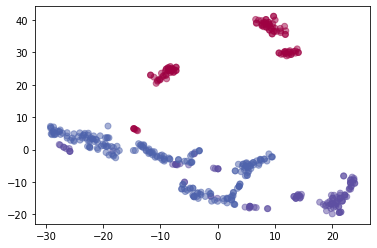

In [416]:
#plt.scatter(X_tsne1[:,0], X_tsne1[:,1])
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], alpha=0.5, c=label5, cmap=plt.cm.Spectral)
plt.show()

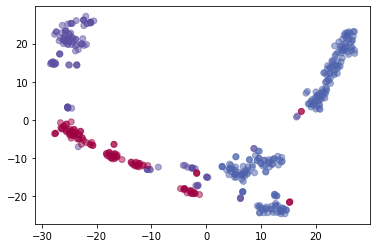

In [417]:
plt.scatter(X_tsne3[:,0], X_tsne3[:,1], alpha=0.5, c=label5, cmap=plt.cm.Spectral)
plt.show()

# 同一个人不同的视频

In [210]:
pd.value_counts(train['userId'])

111221    240
46388     240
8681      234
86834     230
84209     226
         ... 
80107       2
78058       2
76009       2
71146       2
27332       2
Name: userId, Length: 114465, dtype: int64

In [328]:
data1 = []
data2 = []
data3 = []
data4 = []
label = []
user_label = []
specific = train[train['userId']==111221]
for index, row in train[train['userId']==111221].iterrows():
    label.append(int(row['rating']))
    user_label.append('User A')
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data1.append([itemId, userId, category, gender, age])

length = len(label)

for index, row in train[train['userId']==46388].iterrows():
    label.append(int(row['rating']))
    user_label.append('User B')
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data2.append([itemId, userId, category, gender, age])

for index, row in train[train['userId']==8681].iterrows():
    label.append(int(row['rating']))
    user_label.append('User C')
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data3.append([itemId, userId, category, gender, age])
    
for index, row in train[train['userId']==86834].iterrows():
    label.append(int(row['rating']))
    user_label.append('User D')
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data4.append([itemId, userId, category, gender, age])

In [329]:
specific['category'].nunique()

98

In [330]:
pnn_dnn_list1 = []
pnn_udg_dnn_list1 = []
for num, x in enumerate(data1):
    pnn_dnn_list1.append(pnn_dnn_out.predict(x))
    pnn_udg_dnn_list1.append(pnn_udg_dnn_out.predict(x))

pnn_dnn_list2 = []
pnn_udg_dnn_list2 = []
for num, x in enumerate(data2):
    pnn_dnn_list2.append(pnn_dnn_out.predict(x))
    pnn_udg_dnn_list2.append(pnn_udg_dnn_out.predict(x))
    
pnn_dnn_list3 = []
pnn_udg_dnn_list3 = []
for num, x in enumerate(data3):
    pnn_dnn_list3.append(pnn_dnn_out.predict(x))
    pnn_udg_dnn_list3.append(pnn_udg_dnn_out.predict(x))
    
pnn_dnn_list4 = []
pnn_udg_dnn_list4 = []
for num, x in enumerate(data4):
    pnn_dnn_list4.append(pnn_dnn_out.predict(x))
    pnn_udg_dnn_list4.append(pnn_udg_dnn_out.predict(x))

In [331]:
shape1 = np.array(pnn_udg_dnn_list1).shape[0]
shape2 = np.array(pnn_udg_dnn_list2).shape[0]
shape3 = np.array(pnn_udg_dnn_list3).shape[0]
shape4 = np.array(pnn_udg_dnn_list4).shape[0]
from sklearn import preprocessing
tsne = manifold.TSNE(n_components=2, init='pca')

In [332]:
tsne1 = tsne.fit_transform(np.array(np.array(pnn_dnn_list1).reshape(shape1, 80)))
tsne2 = tsne.fit_transform(np.array(np.array(pnn_dnn_list2).reshape(shape2, 80)))
tsne3 = tsne.fit_transform(np.array(np.array(pnn_dnn_list3).reshape(shape3, 80)))
tsne4 = tsne.fit_transform(np.array(np.array(pnn_dnn_list4).reshape(shape4, 80)))

udg_tsne1 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list1).reshape(shape1, 80)))
udg_tsne2 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list2).reshape(shape2, 80)))
udg_tsne3 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list3).reshape(shape3, 80)))
udg_tsne4 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list4).reshape(shape4, 80)))

min_max_scaler = preprocessing.MinMaxScaler()
tsne1 = min_max_scaler.fit_transform(tsne1)
tsne2 = min_max_scaler.fit_transform(tsne2)
tsne3 = min_max_scaler.fit_transform(tsne3)
tsne4 = min_max_scaler.fit_transform(tsne4)

udg_tsne1 = min_max_scaler.fit_transform(udg_tsne1)
udg_tsne2 = min_max_scaler.fit_transform(udg_tsne2)
udg_tsne3 = min_max_scaler.fit_transform(udg_tsne3)
udg_tsne4 = min_max_scaler.fit_transform(udg_tsne4)

In [333]:
x_data = np.array(list(tsne1[:,0]) + list(tsne2[:,0]) + list(tsne3[:,0]) + list(tsne4[:,0]) + 
                 list(udg_tsne1[:,0]) + list(udg_tsne2[:,0]) + list(udg_tsne3[:,0]) + list(udg_tsne4[:,0]))
y_data = np.array(list(tsne1[:,1]) + list(tsne2[:,1]) + list(tsne3[:,1]) + list(tsne4[:,1]) + 
                 list(udg_tsne1[:,1]) + list(udg_tsne2[:,1]) + list(udg_tsne3[:,1]) + list(udg_tsne4[:,1]))

In [334]:
df = pd.DataFrame()
df['x'] = x_data
df['y'] = y_data
df['label'] = label + label
df['user'] = user_label + user_label
df['model'] = ['base model']*len(label) + ['UDG model']*len(label)

df.label[df.label==0]='dislike'
df.label[df.label==1]='like'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


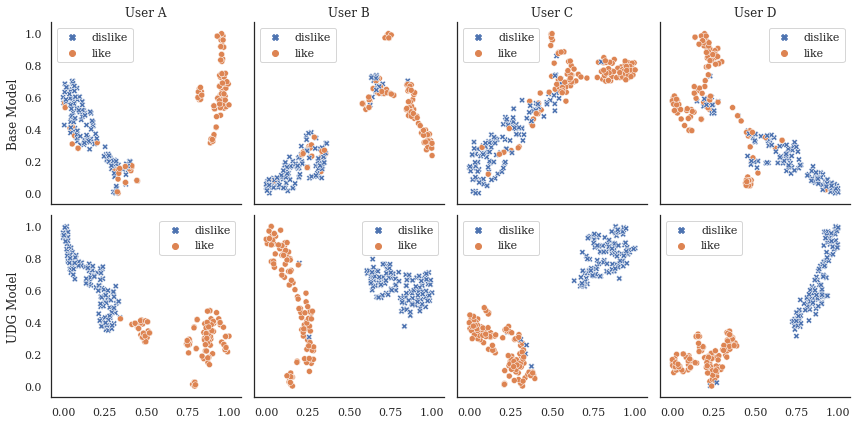

In [367]:
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
g = sns.FacetGrid(df, col="user", row="model", margin_titles=True)
markers = {"dislike": 'X', "like": "o"}
g.map_dataframe(sns.scatterplot, x="x", y="y", hue="label", hue_order=['dislike', 'like'], 
                 style='label', markers=markers)
for (row_val, col_val), ax in g.axes_dict.items():
    ax.legend()
    if row_val == "UDG model" and col_val == "User A":
        ax.set_ylabel('UDG Model')
    if row_val == "base model" and col_val == "User A":
        ax.set_ylabel('Base Model')
g.set_titles(col_template="{col_name}", row_template="")
#g.add_legend(loc=6)
#g.tight_layout()
g.savefig("figure.pdf")

In [344]:
g.legend

In [237]:
shape

944

In [238]:
X_tsne1 = tsne.fit_transform(np.array(np.array(pnn_dnn_list).reshape(shape,80)))
X_tsne2 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list).reshape(shape,80)))

In [239]:
min_max_scaler = preprocessing.MinMaxScaler()
pnn_dnn_list_maxmin = min_max_scaler.fit_transform(X_tsne1)
pnn_udg_dnn_list_maxmin = min_max_scaler.fit_transform(X_tsne2)

In [217]:
np.array(list(pnn_dnn_list_maxmin[:,0]) + list(pnn_dnn_list_maxmin[:,0])).shape

(1888,)

In [202]:
df_0 = pd.DataFrame()
df_1 = pd.DataFrame()
df_0['x'] = pnn_dnn_list_maxmin[:,0]
df_0['y'] = pnn_dnn_list_maxmin[:,1]
df_0['label'] = label

df_1['x'] = pnn_dnn_list_maxmin[length:,0]
df_1['y'] = pnn_dnn_list_maxmin[length:,1]
df_1['label'] = label[length:]

df_2 = pd.DataFrame()
df_3 = pd.DataFrame()
df_2['x'] = pnn_udg_dnn_list_maxmin[:,0]
df_2['y'] = pnn_udg_dnn_list_maxmin[:,1]
df_2['label'] = label

df_3['x'] = pnn_udg_dnn_list_maxmin[length:,0]
df_3['y'] = pnn_udg_dnn_list_maxmin[length:,1]
df_3['label'] = label[length:]

%matplotlib inline

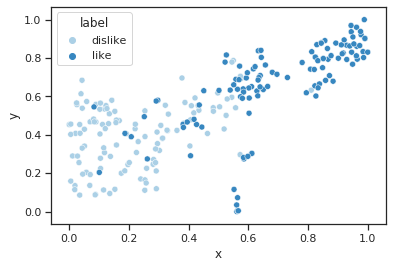

In [161]:
sns.set_style("ticks") 
ax = sns.scatterplot(x='x', y='y', hue="label", data=df_0, palette=sns.color_palette("Blues",2))

In [203]:
sns.set_style("ticks") 
ax = sns.scatterplot(x='x', y='y', hue="label", data=df_0, palette=sns.color_palette("jet_r",87), legend=False)

ValueError: Could not interpret value ` ` for parameter `hue`

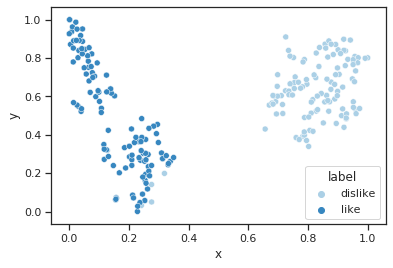

In [162]:
sns.set_style("ticks") 
ax = sns.scatterplot(x='x', y='y', hue="label", data=df_2, palette=sns.color_palette("Blues", 2))

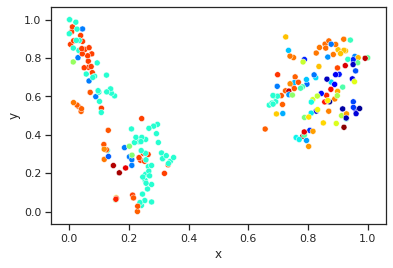

In [201]:
ax = sns.scatterplot(x='x', y='y', hue="label", data=df_2, palette=sns.color_palette("jet_r", 87), legend=False)

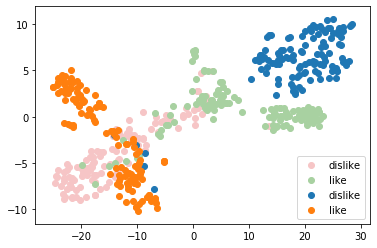

In [458]:
plt.scatter(X_tsne1[:length,0], X_tsne1[:length,1], c='#f6c5c6', label='dislike')
plt.scatter(X_tsne1[length:,0], X_tsne1[length:,1], c='#a8d1a1', label='like')
plt.scatter(X_tsne2[:length,0], X_tsne2[:length,1], label='dislike')
plt.scatter(X_tsne2[length:,0], X_tsne2[length:,1], label='like')
plt.legend()
plt.show()

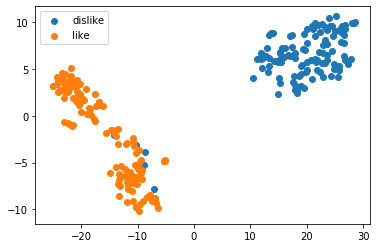

In [456]:
plt.scatter(X_tsne2[:length,0], X_tsne2[:length,1], label='dislike')
plt.scatter(X_tsne2[length:,0], X_tsne2[length:,1], label='like')
plt.legend()
plt.show()

# 按视频分类分不同的目标人群

In [243]:
train1 = train[train['rating']==1]

In [286]:
pd.value_counts(train1['category']).keys()[251]

1580

In [285]:
pd.value_counts(train1['category'])[1499]

149

In [265]:
pd.value_counts(train1['category'])[287]

206

In [287]:
data = []
label = []
for index, row in train1[train1['category']==1499].iterrows():
    label.append(int(row['category']))
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data.append([itemId, userId, category, gender, age])
    
for index, row in train1[train1['category']==1580].iterrows():
    label.append(int(row['category']))
    itemId = np.array([row['itemId']])
    userId = np.array([row['userId']])
    category = np.array([row['category']])
    gender = np.array([row['final_gender_code']])
    age = np.array([row['age_level']])
    data.append([itemId, userId, category, gender, age])       
    

In [288]:
pnn_uid_list = []
pnn_dnn_list = []
pnn_udg_uid_list = []
pnn_udg_uid2_list = []
pnn_udg_dnn_list = []
for num, x in enumerate(data):
    pnn_uid_list.append(pnn_uid_out.predict(x))
    pnn_dnn_list.append(pnn_dnn_out.predict(x))

    pnn_udg_uid_list.append(pnn_udg_uid_out.predict(x))
    pnn_udg_uid2_list.append(pnn_udg_uid_out.predict(x))
    pnn_udg_dnn_list.append(pnn_udg_dnn_out.predict(x))

In [289]:
shape = np.array(pnn_udg_dnn_list).shape[0]
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
pnn_dnn_list_maxmin = min_max_scaler.fit_transform(np.array(pnn_dnn_list).reshape(shape,80))
pnn_udg_dnn_list_maxmin = min_max_scaler.fit_transform(np.array(pnn_udg_dnn_list).reshape(shape,80))

tsne = manifold.TSNE(n_components=2)
X_tsne1 = tsne.fit_transform(np.array(np.array(pnn_dnn_list).reshape(shape,80)))
X_tsne2 = tsne.fit_transform(np.array(np.array(pnn_udg_dnn_list).reshape(shape,80)))

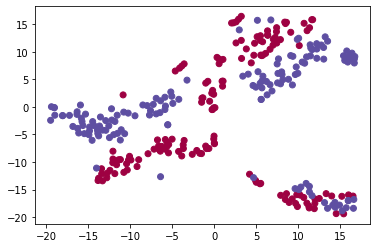

In [290]:
plt.scatter(X_tsne1[:,0], X_tsne1[:,1], c=label, cmap=plt.cm.Spectral)
plt.show()

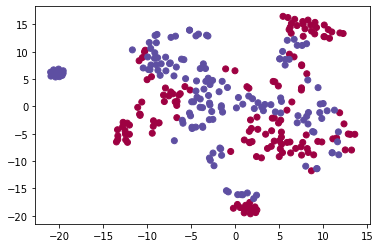

In [291]:
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=label, cmap=plt.cm.Spectral)
plt.show()

In [422]:
a = np.array([[1,2],[3,4]])

In [453]:
a[1:,0]

array([3])